# Multi-site Poisson count calibration

This demo fits **separate** calibration parameters \((\alpha_s, \beta_s)\) per site. Each site can have a different number of labeled and unlabeled images (ragged arrays). Observations are assigned to sites via `site_id_labeled` and `site_id_unlabeled` (1-indexed).

**Requirements:** `cmdstanpy` and a working CmdStan install. See the single-site demo for installation notes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

## Simulate multi-site data

We simulate several sites with different true \((\alpha, \beta)\) and different total images per site and different numbers of labeled images per site.

In [3]:
N_sites = 3
rng = np.random.default_rng(43)
epsilon = 1e-6

# True (alpha, beta) per site — can differ by site
alpha_true_sites = np.array([0.2, 0.5, -0.1])
beta_true_sites = np.array([0.5, 0.8, 0.3])

# Total images per site (ragged)
N_images_per_site = np.array([200, 350, 150])
site_ids_full = np.repeat(np.arange(N_sites), N_images_per_site) + 1  # 1-indexed for Stan
N_total = len(site_ids_full)

# Simulate true counts and predictions per image using each image's site
true_counts_multi = np.zeros(N_total, dtype=np.int64)
predicted_counts_multi = np.zeros(N_total)
idx = 0
for s in range(N_sites):
    n = N_images_per_site[s]
    true_counts_multi[idx : idx + n] = rng.binomial(1, 0.6, n) * rng.poisson(1.5, n)
    for i in range(n):
        pred = np.exp(
            alpha_true_sites[s]
            + beta_true_sites[s] * np.log(true_counts_multi[idx + i] + epsilon)
        )
        predicted_counts_multi[idx + i] = rng.poisson(pred)
    idx += n

# Label a subset per site (ragged: different N_labeled per site)
N_labeled_per_site = np.array([30, 80, 20])
labeled_indices = []
for s in range(N_sites):
    site_inds = np.where(site_ids_full == s + 1)[0]
    n_label = min(N_labeled_per_site[s], len(site_inds))
    chosen = rng.choice(site_inds, size=n_label, replace=False)
    labeled_indices.extend(chosen)
labeled_indices = np.array(labeled_indices)
unlabeled_mask = np.ones(N_total, dtype=bool)
unlabeled_mask[labeled_indices] = False

# Flat vectors and site id vectors for Stan
pred_labeled = predicted_counts_multi[labeled_indices].astype(np.float64)
truth_labeled = true_counts_multi[labeled_indices]  # keep int for Stan
site_id_labeled = site_ids_full[labeled_indices].astype(np.int32)

pred_unlabeled = predicted_counts_multi[unlabeled_mask].astype(np.float64)
site_id_unlabeled = site_ids_full[unlabeled_mask].astype(np.int32)
truth_unlabeled = true_counts_multi[unlabeled_mask]

N_labeled = len(pred_labeled)
N_unlabeled = len(pred_unlabeled)
print(
    f"Sites: {N_sites}. Labeled: {N_labeled} "
    f"(per site: {[int(np.sum(site_id_labeled == s + 1)) for s in range(N_sites)]}). "
    f"Unlabeled: {N_unlabeled}."
)

Sites: 3. Labeled: 130 (per site: [30, 80, 20]). Unlabeled: 570.


## Fit the multi-site model

In [4]:
data = {
    "N_sites": N_sites,
    "N_labeled": N_labeled,
    "N_unlabeled": N_unlabeled,
    "predicted_counts_labeled": pred_labeled,
    "true_counts_labeled": truth_labeled.tolist(),  # Stan expects list of ints
    "site_id_labeled": site_id_labeled.tolist(),
    "predicted_counts_unlabeled": pred_unlabeled,
    "site_id_unlabeled": site_id_unlabeled.tolist(),
    "epsilon": epsilon,
}

model = CmdStanModel(stan_file="../stan_models/multi_site_count_calibration.stan")
fit = model.sample(data=data, seed=456, show_progress=True)

09:23:28 - cmdstanpy - INFO - compiling stan file /Users/LOF19/maria_poisson_calibration/stan_models/multi_site_count_calibration.stan to exe file /Users/LOF19/maria_poisson_calibration/stan_models/multi_site_count_calibration
09:23:39 - cmdstanpy - INFO - compiled model executable: /Users/LOF19/maria_poisson_calibration/stan_models/multi_site_count_calibration
09:23:39 - cmdstanpy - INFO - CmdStan start processing
chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]


chain 1:  50%|█████     | 1000/2000 [00:00<00:00, 12804.42it/s, (Sampling)]


chain 1:  55%|█████▌    | 1100/2000 [00:00<00:00, 10389.40it/s, (Sampling)]


chain 2: 100%|██████████| 2000/2000 [00:00<00:00, 5439.20it/s, (Sampling completed)] 

chain 3: 100%|██████████| 2000/2000 [00:00<00:00, 5445.01it/s, (Sampling completed)] 


chain 4: 100%|██████████| 2000/2000 [00:00<00:00, 5448.17it/s, (Sampling completed)] 


09:23:40 - cmdstanpy - INFO - CmdStan done processing.


## Maximum count per site (with CIs)

Using both labeled (observed) and unlabeled (posterior predictive) counts, we estimate the maximum number of rays in any single image at each site. Each MCMC draw imputes unlabeled counts and takes the max over all images at that site; the distribution of that max gives a posterior and 90% CI.

In [5]:
max_count_draws = fit.stan_variable("max_count_site")  # shape (draws, N_sites)
print("Per-site maximum rays in any image (posterior median and 90% CI):")
for s in range(N_sites):
    mc = max_count_draws[:, s]
    lo, hi = np.percentile(mc, [5, 95])
    med = np.median(mc)
    print(f"  Site {s + 1}: max = {int(med)}  90% CI = [{int(lo)}, {int(hi)}]")

# Compare to true max from simulation (for demo validation)
print("\nTrue max per site (from simulation):")
for s in range(N_sites):
    at_site = true_counts_multi[site_ids_full == s + 1]
    true_max = int(np.max(at_site))
    print(f"  Site {s + 1}: {true_max}")

Per-site maximum rays in any image (posterior median and 90% CI):
  Site 1: max = 6  90% CI = [4, 8]
  Site 2: max = 7  90% CI = [6, 9]
  Site 3: max = 7  90% CI = [4, 10]

True max per site (from simulation):
  Site 1: 5
  Site 2: 6
  Site 3: 7


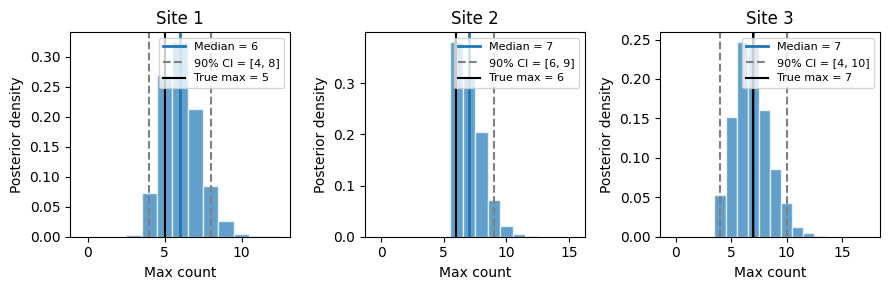

In [9]:
# Plot: posterior distribution of max count per site
fig, axes = plt.subplots(1, N_sites, figsize=(3 * N_sites, 3), squeeze=False)
for s in range(N_sites):
    ax = axes[0, s]
    mc = max_count_draws[:, s]
    ax.hist(mc, bins=np.arange(int(mc.max()) + 2) - 0.5, color="C0", alpha=0.7, edgecolor="white", density=True)
    lo, hi = np.percentile(mc, [5, 95])
    ax.axvline(np.median(mc), color="C0", lw=2, label=f"Median = {int(np.median(mc))}")
    ax.axvline(lo, color="gray", ls="--", lw=1.5)
    ax.axvline(hi, color="gray", ls="--", lw=1.5, label=f"90% CI = [{int(lo)}, {int(hi)}]")
    true_max_s = int(np.max(true_counts_multi[site_ids_full == s + 1]))
    ax.axvline(true_max_s, color="black", lw=1.5, label=f"True max = {true_max_s}")
    ax.set_xlabel("Max count")
    ax.set_ylabel("Posterior density")
    ax.set_title(f"Site {s + 1}")
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## Maximum count per site (with CIs)

Using both labeled (observed) and unlabeled (posterior predictive) counts, we estimate the maximum number of rays in any single image at each site. Each MCMC draw imputes unlabeled counts and takes the max over all images at that site; the distribution of that max gives a posterior and 90% CI.

In [10]:
max_count_draws = fit.stan_variable("max_count_site")  # shape (draws, N_sites)
print("Per-site maximum rays in any image (posterior median and 90% CI):")
for s in range(N_sites):
    mc = max_count_draws[:, s]
    lo, hi = np.percentile(mc, [5, 95])
    med = np.median(mc)
    print(f"  Site {s + 1}: max = {int(med)}  90% CI = [{int(lo)}, {int(hi)}]")

# Compare to true max from simulation (for demo validation)
print("\nTrue max per site (from simulation):")
for s in range(N_sites):
    at_site = true_counts_multi[site_ids_full == s + 1]
    true_max = int(np.max(at_site))
    print(f"  Site {s + 1}: {true_max}")

Per-site maximum rays in any image (posterior median and 90% CI):
  Site 1: max = 6  90% CI = [4, 8]
  Site 2: max = 7  90% CI = [6, 9]
  Site 3: max = 7  90% CI = [4, 10]

True max per site (from simulation):
  Site 1: 5
  Site 2: 6
  Site 3: 7


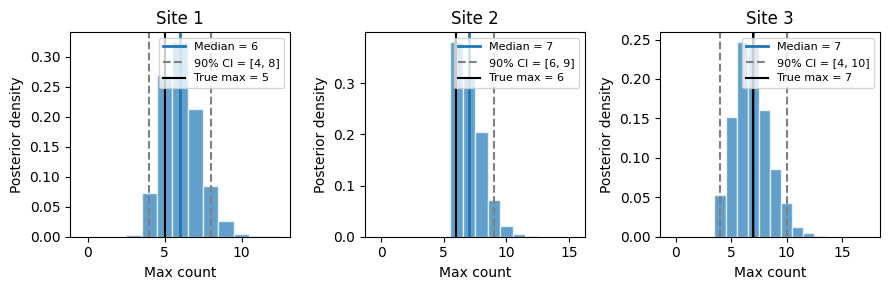

In [11]:
# Plot: posterior distribution of max count per site
fig, axes = plt.subplots(1, N_sites, figsize=(3 * N_sites, 3), squeeze=False)
for s in range(N_sites):
    ax = axes[0, s]
    mc = max_count_draws[:, s]
    ax.hist(mc, bins=np.arange(mc.max() + 2) - 0.5, color="C0", alpha=0.7, edgecolor="white", density=True)
    lo, hi = np.percentile(mc, [5, 95])
    ax.axvline(np.median(mc), color="C0", lw=2, label=f"Median = {int(np.median(mc))}")
    ax.axvline(lo, color="gray", ls="--", lw=1.5)
    ax.axvline(hi, color="gray", ls="--", lw=1.5, label=f"90% CI = [{int(lo)}, {int(hi)}]")
    true_max_s = int(np.max(true_counts_multi[site_ids_full == s + 1]))
    ax.axvline(true_max_s, color="black", lw=1.5, label=f"True max = {true_max_s}")
    ax.set_xlabel("Max count")
    ax.set_ylabel("Posterior density")
    ax.set_title(f"Site {s + 1}")
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()